# Text-based Depression Detection Model


In [33]:
from collections import Counter
from typing import Tuple

import joblib
import nltk
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

from preprocessing.loader_results import ResultsLoader
from preprocessing.loader_text import TextLoader

#Constants
RANDOM_SEED = 42
DATA_PERCENTAGE = 0  # 100% of the data
FIGURE_SIZE = (15, 8)

# Hyperparameter tuning using Grid Search
PARAM_GRID = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__min_df': [1, 2],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}


## Data Preparation

In [34]:
def load_data(percentage: float = DATA_PERCENTAGE, random_state: int = RANDOM_SEED) -> Tuple[
    pd.DataFrame, pd.DataFrame]:
    # Initialize loaders
    results_loader = ResultsLoader()
    text_loader = TextLoader()

    # Load data
    df_result = results_loader.get_data(percentage=percentage, random_state=random_state)
    df_text = text_loader.get_data(percentage=percentage, random_state=random_state)

    return df_text, df_result


# Load the data
df_text, df_result = load_data()

# Display data
print("Text Features:")
display(df_text)
print("\nResults:")
display(df_result)

Text Features:


,TRANSCRIPT_text
ID,
475,synch introv4confirmation hi im ellie thanks c...
386,synch introv4confirmation hi im ellie thanks c...
361,hi im ellie thanks coming today created talk p...
492,synch introv4confirmation hi im ellie thanks c...
414,sync introv4confirmation hi im ellie thanks co...
...,...
464,sync introv4confirmation hi im ellie thanks co...
420,synch introv4confirmation hi im ellie thanks c...
334,hi im ellie thanks coming today created talk p...



Results:


,PHQ_Binary
ID,
475,0
386,1
361,0
492,0
414,1
...,...
464,0
420,0
334,0


## Exploratory Data Analysis

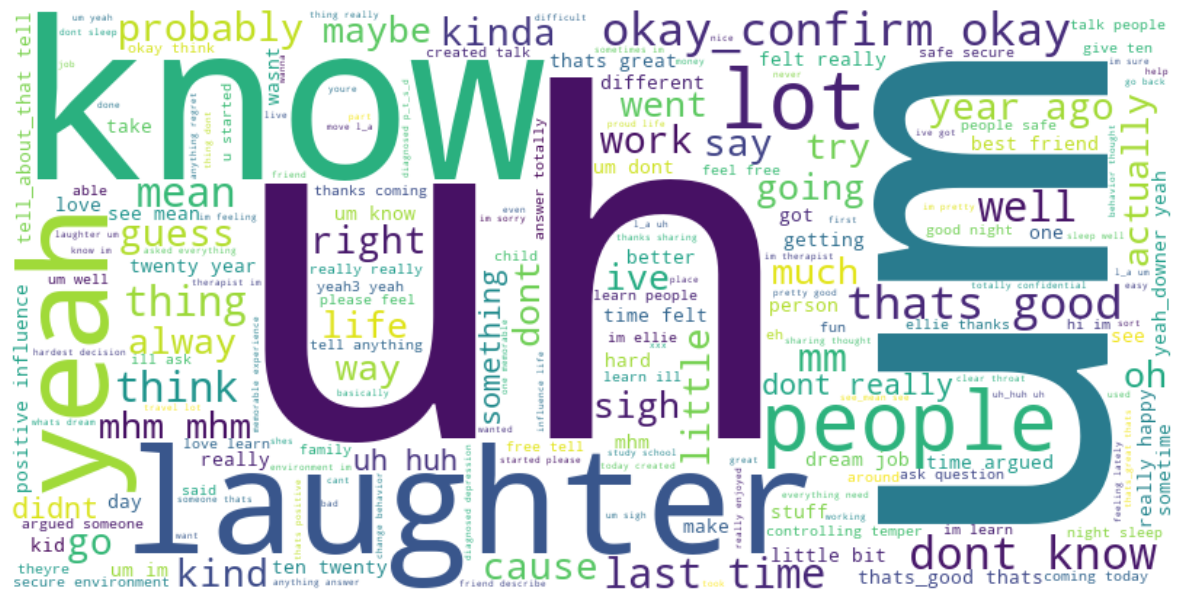

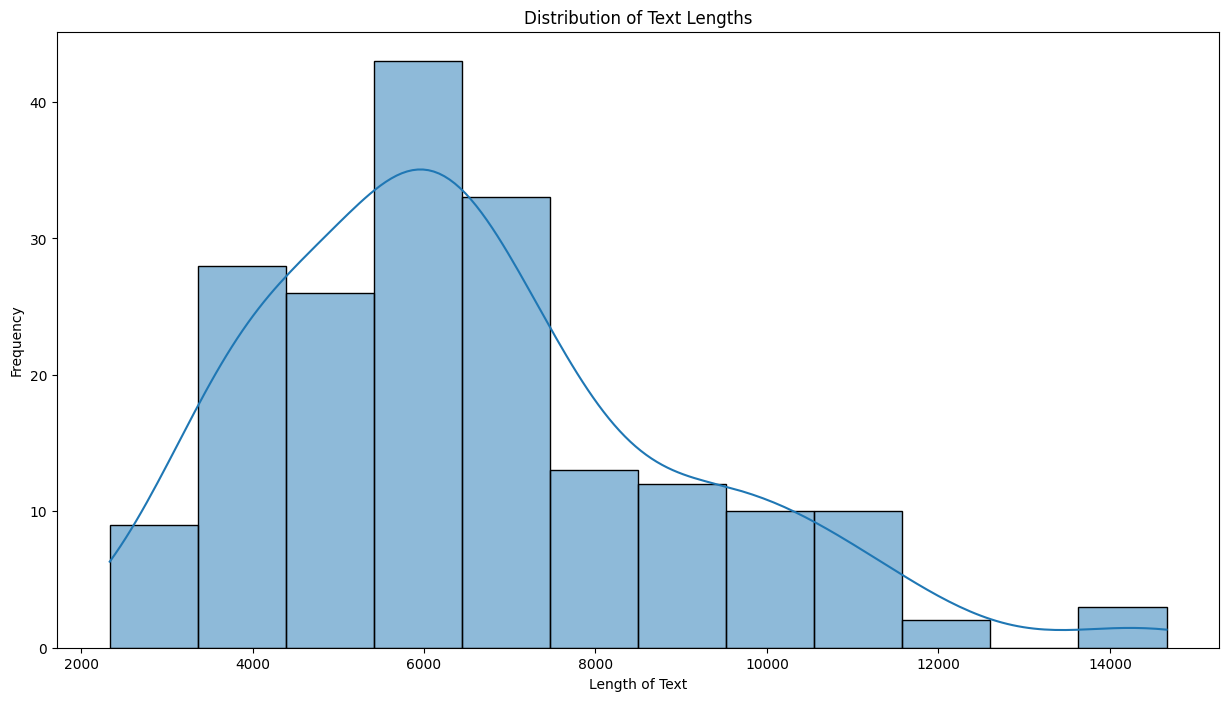

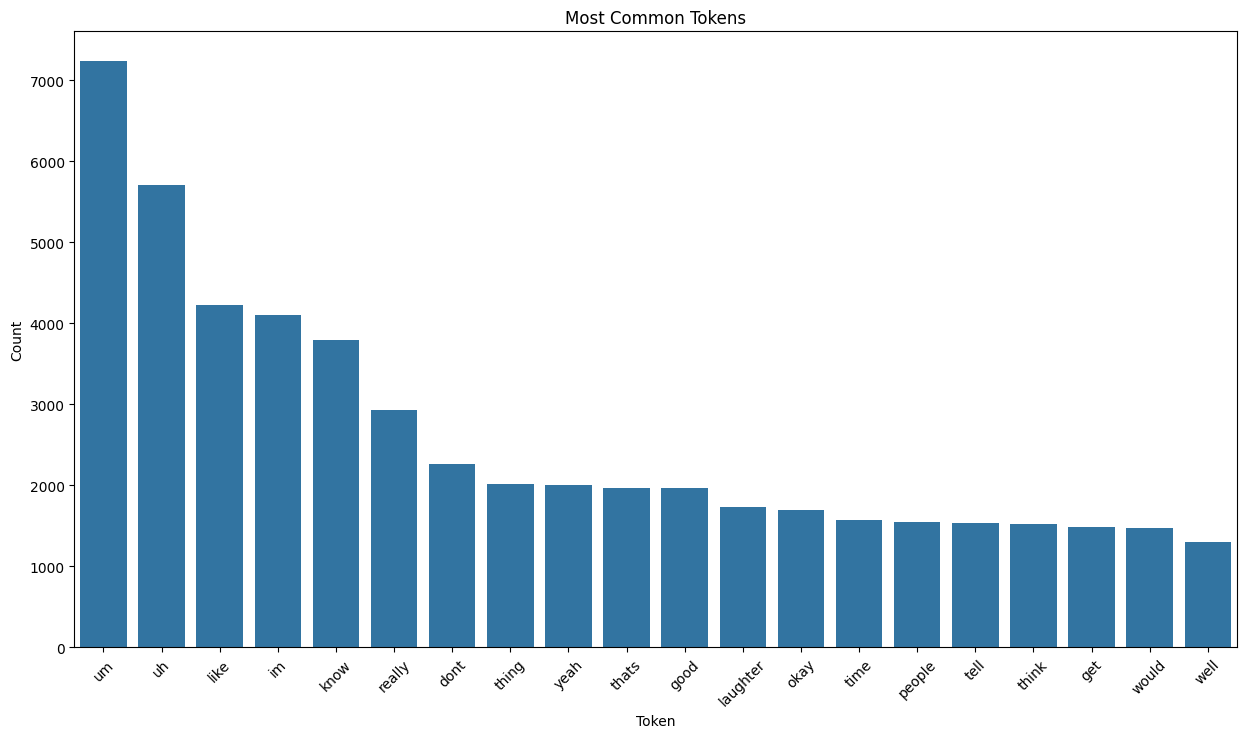

In [35]:

def plot_wordcloud():
    # Word Cloud for the text data
    global text, wordcloud
    text = " ".join(df_text['TRANSCRIPT_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


def plot_length_of_words():
    # Length of words
    X_train_lengths = df_text['TRANSCRIPT_text'].apply(len)
    plt.figure(figsize=FIGURE_SIZE)
    sns.histplot(X_train_lengths, kde=True)
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Length of Text')
    plt.ylabel('Frequency')
    plt.show()


def plot_most_common_tokens():
    # Most common tokens
    all_tokens = nltk.word_tokenize(text)
    common_tokens = Counter(all_tokens).most_common(20)
    tokens_df = pd.DataFrame(common_tokens, columns=['Token', 'Count'])
    plt.figure(figsize=FIGURE_SIZE)
    sns.barplot(data=tokens_df, x='Token', y='Count')
    plt.title('Most Common Tokens')
    plt.xlabel('Token')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


plot_wordcloud()
plot_length_of_words()
plot_most_common_tokens()

## Data Splitting

In [36]:

df = pd.merge(df_text, df_result, on="ID")

X_train, X_test, y_train, y_test = train_test_split(df['TRANSCRIPT_text'], df['PHQ_Binary'], test_size=0.2,random_state=RANDOM_SEED)

## Pipeline & Hyperparameter Tuning

In [37]:

# Create a pipeline with TF-IDF and a classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),  # Using bigrams
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED))
])

grid_search = GridSearchCV(pipeline, PARAM_GRID, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__n_estimators': [100, 200],
                         'tfidf__max_df': [0.75, 1.0],
                         'tfidf__min_df': [1, 2]},
             scoring='accuracy')

## Model Evaluation

y_pred: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
y_test: [0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0
 0]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.96      0.83        27
           1       0.50      0.09      0.15        11

    accuracy                           0.71        38
   macro avg       0.61      0.53      0.49        38
weighted avg       0.66      0.71      0.63        38



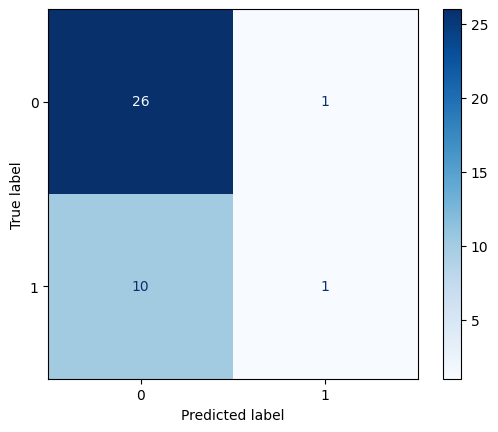

ssss


In [38]:

y_pred = grid_search.predict(X_test)

y_test = y_test.to_numpy()
# Debug: Check the shapes and types of y_pred
print(f'y_pred: {y_pred}')
print(f'y_test: {y_test}')

# Generate and display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print("ssss")



## Save Model

In [39]:

joblib.dump(grid_search.best_estimator_, 'text_model.joblib')
print('Model saved!')

Model saved!
